# Troll Classification (continued)

My overall project objective is to determine whether I can accurately predict whether a given tweet is from trump or a troll. This is a classification problem, but I'm assuming I'll need to rely heavily on NLP to interpret the payload of the tweet itself, and to generate some features that will prove useful in classification

Ahead of time, and to help me keep focused, I'm working through the problem this way

Pre-Notebook - Defining the business problem (this is contained within the lightning talk)
Book One - Data Acquisition, Cleaning & Initial EDA
Book Two - Enhanced EDA, NLP (to generate features), Classifiers
Bonus - To determine whether there are sentiment or content shifts over time

# Book 2: Extended EDA: NLP & Classification
Unlike 'typical' NLP, I've made a decision not to strip out the smaller words. I've done this as I think Trump's tweets in particular are going to feature smaller words and utterances, and by removing them I might lose predictive power. In fact, I think some of what makes Trump's tweets recognisable is their non-standard use of language and grammar. Let's see how we go...

At a summary level, I'm going to undertake the following steps on the 'tweet' column to try and generate additional features for use in the next, classification, step:

Strip the data of superfluous characters & content (in the case of twitter, this includes things like 'RT' for re-tweet and the '@' symbol denoting a user handle Stemming, to remove word endings and tense specifics that don't (in this context) add to the meaning of the words Tokenisation, so I can prepare a matrix version of the data for later operations Vector and encoding operations such as Bag of words, and TF-IDF. Whilst both are different, in this context I'll use them to determine word frequency (and in the case of TF-IDF as a regularisation process) My data should then be ready for visualisation and able to generate features for use in classification

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import string
import nltk
import re
import numpy as np
import scipy as sp
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

#Jose advised I manage dependencies through a dependencies or requirements.txt. I will do this, 
#I'm keeping them here for my own reference!

In [2]:
#Acquiring the dataset created in Book 1

df = pd.read_csv("/Users/garysanders/Desktop/my_repo/unit_projects/data/merged_df.csv")

In [3]:
#tidy up
df.drop("Unnamed: 0",axis=1,inplace=True)

In [4]:
#more tidy up
df.drop("index",axis=1,inplace=True)

In [5]:
#in readiness for modelling, i'm going to create a dummy variable to transform the 'trump / troll' source 
#indicator into a binary 'is_trump' where '1' is trump and 0 is troll

df2 = pd.get_dummies(df['source'], drop_first=True)
df2.head()

,trump
0,1
1,1
2,1
3,1
4,1


In [6]:
df2 = pd.DataFrame(df2)
df2.rename(columns={'trump' : 'is_trump'}, inplace=True)

In [7]:
df.drop("source",axis=1,inplace=True)

In [8]:
df = pd.concat([df, df2], axis=1)
df.head(3)

,create_date,id,is_retweet,tweet,is_trump
0,2018-11-29 22:47:59,1068275406141149184,0,We have been working hard on this - and it’s o...,1
1,2018-11-29 22:43:12,1068274204208812032,0,With all of the new books coming out you can't...,1
2,2018-11-29 22:34:18,1068271965343862784,0,".@DBongino’s new book, ""Spygate: The Attempted...",1


### 2.1 Stripping the tweet data but not (yet) the stop words
For now, I'm not removing stop words, as I have a hypothesis that this is a distinctive feature for trump. i'll test out my hypothesis later on

In [9]:
#removing twitter handles. this function found on twitter sentiment analysis uses regular expressions and makes 
#sense in the context
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt

In [10]:
#now using the function to remove twitter handles
df['tidy_tweet'] = np.vectorize(remove_pattern)(df['tweet'], "@[\w]*")

In [11]:
#hmmm. I can see that the use of a twitter handle as a name (e.g. @gary's) and my cleaning 
#has left 's in the tidy_tweet column. I'll clean it up

df['tidy_tweet'] = df['tidy_tweet'].str.replace("'s", " ")

In [12]:
#removing the 'RT' retweet reference. it's certain that the troll data would contain this, but only somewhat 
#likely the trump data would. Given the nature of the troll data, it would thus create multi-collinearity
df['tidy_tweet'] = df['tidy_tweet'].str.replace("RT", " ")

### 2.2 First Models: Logistic Regression & Count Vectorizer

In [13]:
# Defining X and y and developing the train / test split
X = df.tidy_tweet
y = df.is_trump

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=21,stratify=y,test_size=0.20)

print(len(X_train), len(X_test))
print(len(y_train), len(y_test))

56616 14155
56616 14155


In [14]:
#preparing for accuracy measurement: the baseline is the majority class over the total
baseline = 40000/70701
print(baseline)

0.5657628604970226


In [15]:
# Using CountVectorizer to create matrices from X_train and X_test.
vect = CountVectorizer()
X_train_doc = vect.fit_transform(X_train)
X_test_doc = vect.transform(X_test)

X_train_doc.shape

(56616, 103121)

In [23]:
#let's try and build a first model, and see how well it performs before we try harder on NLP and switch 
#models. This version of the model uses optimal C which is generated further down (and was discovered in an early version )

lr = LogisticRegression(C=1.0)
lr.fit(X_train_doc, y_train)
y_pred = lr.predict(X_test_doc)

In [87]:
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, recall_score, f1_score, roc_auc_score

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print(f"Accuracy: {acc}\tPrecision: {prec}\tRecall: {rec}\tF-1: {f1}\tRoc_Auc: {roc_auc}\tConfusion: {confusion}")

Accuracy: 0.9168491699046274	Precision: 0.9059034572733203	Recall: 0.9025182778229082	F-1: 0.9042076991942705	Roc_Auc: 0.9151966389114541	Confusion: [[7423  577]
 [ 600 5555]]


This is a great start, 0.92 accuracy on logistic regression, with Precision, Recall, F1 and Roc/Auc all above 0.90, and a similar set of positive outcomes across the confusion matrix. More to come: we'll try the rest of the NLP steps, stop words and other model methods

The false positive rate for this initial model is 0.072*

*FP/(FP+TN) = 577/(577+7423)

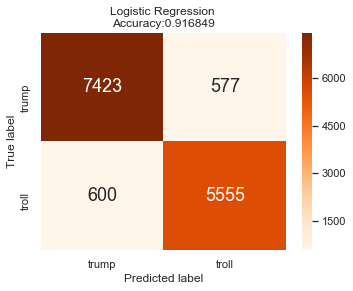

In [25]:
from sklearn.metrics import precision_recall_fscore_support

cm = confusion_matrix(y_test, y_pred) 

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ['trump','troll'], 
                     columns = ['trump','troll'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True, annot_kws={"size": 18},cmap='Oranges',fmt='g')

plt.title('Logistic Regression \nAccuracy:{0:2f}'.format(accuracy_score(y_test, y_pred)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### 2.3 Logistic Regression Optimisation (Grid Search, Optimising C, Cross Validation)

In [26]:
# Using CountVectorizer to create matrices from X_train and X_test.
vect = CountVectorizer()
X_train_doc = vect.fit_transform(X_train)
X_test_doc = vect.transform(X_test)

X_train_doc.shape

(56616, 103121)

In [20]:
#let's a good degree of regularization within the sk-learn version of logistic regression, but 
#we can still optimise the 'C' parameter

from sklearn.model_selection import GridSearchCV, StratifiedKFold

grid = GridSearchCV(LogisticRegression(),
                    param_grid={"C": np.logspace(-2, 2, 5)},
                    scoring="accuracy",
                    cv=StratifiedKFold(10))

grid.fit(X_train_doc, y_train);

In [21]:
grid.best_score_

0.9208174367669917

In [22]:
grid.best_params_

{'C': 1.0}

We're showing an improvement! Accuracy at 0.920 for Grid vs 0.916 for Logistic Regression. I'm going to re-run the Logistic Regression with Optimal C (C is now 1.0, it was 4.64)

### 2.4 Stop Words, Stemming & Lemmatisation (including N-Grams)

In [27]:
#removing stop words to see if it improves accuracy (my hypothesis above was that it would not)
df_st = CountVectorizer(stop_words='english')
X_train_stop = df_st.fit_transform(X_train)
X_test_stop = df_st.transform(X_test)

X_train_stop.shape

(56616, 102822)

In [28]:
#as suspected, removing stop words is reducing accuracy - indeed it's performing worse on all measures. Won't 
#use this code branch further
lr.fit(X_train_stop, y_train)
y_pred2 = lr.predict(X_test_stop)

acc2 = accuracy_score(y_test, y_pred2)
prec2 = precision_score(y_test, y_pred2)
rec2 = recall_score(y_test, y_pred2)
f12 = f1_score(y_test, y_pred2)
confusion2 = confusion_matrix(y_test, y_pred2)
roc_auc2 = roc_auc_score(y_test, y_pred2)

print(f"Accuracy: {acc2}\tPrecision: {prec2}\tRecall: {rec2}\tF-1: {f12}\tRoc_Auc: {roc_auc2}\tConfusion: {confusion2}")


Accuracy: 0.9152949487813493	Precision: 0.9033203125	Recall: 0.9017059301380991	F-1: 0.9025123993820635	Roc_Auc: 0.9137279650690495	Confusion: [[7406  594]
 [ 605 5550]]


In [29]:
#now trying bi-grams to see if that has any effect. I'm not going to apply min

ng = CountVectorizer(ngram_range=(2, 2))

X_train_ng = ng.fit_transform(X_train)
X_test_ng = ng.transform(X_test)

X_train_ng.shape

(56616, 420786)

In [30]:
#bi-grams are also reducing accuracy (makes sense given the short form corpus)
lr.fit(X_train_ng, y_train)
y_pred3 = lr.predict(X_test_ng)

accuracy_score(y_test, y_pred3)

0.8789120452137054

In [31]:
#let's see if reducing features has any effect

ng50 = CountVectorizer(ngram_range=(2, 2), max_features=50000)

X_train_ng50 = ng50.fit_transform(X_train)
X_test_ng50 = ng50.transform(X_test)

X_train_ng50.shape

(56616, 50000)

In [32]:
#haven't lost much accuracy given the massive reduction in features. we're still below the original LogReg though
lr.fit(X_train_ng50, y_train)
y_pred4 = lr.predict(X_test_ng50)

accuracy_score(y_test, y_pred4)

0.8772165312610385

In [33]:
#Seems doubtful that min_df will work on such a short corpus of data as a tweet, given the pattern above, but let's see 

kit_sink = CountVectorizer(ngram_range=(1, 2), min_df=2)
X_train_kit_sink = kit_sink.fit_transform(X_train)
X_test_kit_sink = kit_sink.transform(X_test)

X_train_kit_sink.shape

(56616, 102326)

In [34]:
#i was wrong, we have an accuracy improvement!
lr.fit(X_train_kit_sink, y_train)
y_pred5 = lr.predict(X_test_kit_sink)

accuracy_score(y_test, y_pred5)

0.9232073472271283

In [35]:
#on reflection, I didn't try a 1-gram. I wonder how that would have performed vs a bi-gram

ng1 = CountVectorizer(ngram_range=(1, 1))

X_train_ng1 = ng1.fit_transform(X_train)
X_test_ng1 = ng1.transform(X_test)

X_train_ng1.shape

(56616, 103121)

In [36]:
#most of the improved accuracy came through the use of the 1-gram, rather than the min_df. 
#however, the min_df is *slightly* better so we'll proceed with that one (y_pred5)
lr.fit(X_train_ng1, y_train)
y_pred6 = lr.predict(X_test_ng1)

accuracy_score(y_test, y_pred6)

0.9168491699046274

In [37]:
#confusion matrix for our best performer to date, y_pred5. Most improvement comes from improved trump-class prediction

acc = accuracy_score(y_test, y_pred5)
prec = precision_score(y_test, y_pred5)
rec = recall_score(y_test, y_pred5)
f1 = f1_score(y_test, y_pred5)
confusion = confusion_matrix(y_test, y_pred5)
roc_auc = roc_auc_score(y_test, y_pred5)

print(f"Accuracy: {acc}\tPrecision: {prec}\tRecall: {rec}\tF-1: {f1}\tRoc_Auc: {roc_auc}\tConfusion: {confusion}")

Accuracy: 0.9232073472271283	Precision: 0.9165023011176857	Recall: 0.9059301380991064	F-1: 0.9111855543753574	Roc_Auc: 0.9212150690495532	Confusion: [[7492  508]
 [ 579 5576]]


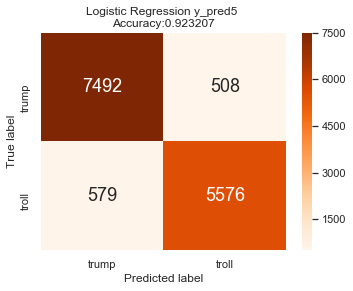

In [38]:
cm2 = confusion_matrix(y_test, y_pred5) 

# Transform to df for easier plotting
cm2_df = pd.DataFrame(cm2,
                     index = ['trump','troll'], 
                     columns = ['trump','troll'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm2_df, annot=True, annot_kws={"size": 18},cmap='Oranges',fmt='g')

plt.title('Logistic Regression y_pred5 \nAccuracy:{0:2f}'.format(accuracy_score(y_test, y_pred5)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### 2.5 TF-IDF

In [39]:
tokenized_tweet = df['tidy_tweet'].apply(lambda x: x.split())
tokenized_tweet.head()

0    [We, have, been, working, hard, on, this, -, a...
1    [With, all, of, the, new, books, coming, out, ...
2    [.’s, new, book,, "Spygate:, The, Attempted, S...
3    [....They, have, really, done, a, great, job, ...
4    [., and, Arthur, Laffer,, two, very, talented,...
Name: tidy_tweet, dtype: object

In [40]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer('english')

stem = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x])
print(stem)

0        [we, have, been, work, hard, on, this, -, and,...
1        [with, all, of, the, new, book, come, out, you...
2        [., new, book,, "spygate:, the, attempt, sabot...
3        [....they, have, realli, done, a, great, job, ...
4        [., and, arthur, laffer,, two, veri, talent, m...
5        [., has, written, an, absolut, fascin, book, (...
6        [....in, argentina, with, presid, vladimir, pu...
7        [base, on, the, fact, that, the, ship, and, sa...
8        [billion, of, dollar, are, pour, into, the, co...
9        [when, will, this, illeg, joseph, mccarthi, st...
10       [did, you, ever, see, an, investig, more, in, ...
11       [general, motor, is, veri, counter, to, what, ...
12       [so, much, happen, with, the, now, discredit, ...
13       [sebastian, gorka,, a, veri, talent, man, who,...
14       [on, behalf, of, melania, and, the, entir, tru...
15       [steel, dynam, announc, that, it, will, build,...
16       [the, reason, that, the, small, truck, busi, i.

In [41]:
from textblob import Word
lemm = tokenized_tweet.apply(lambda x: " ".join([Word(i).lemmatize() for i in x]))
lemm.head()

0    We have been working hard on this - and it’s o...
1    With all of the new book coming out you can't ...
2    .’s new book, "Spygate: The Attempted Sabotage...
3    ....They have really done a great job in captu...
4    . and Arthur Laffer, two very talented men, ha...
Name: tidy_tweet, dtype: object

In [42]:
#turning this object into a dataframe so I can merge it back with the main df
lemm2 = pd.DataFrame(lemm)
lemm2.rename(columns={'tidy_tweet' : 'lemm'}, inplace=True)

In [43]:
#now merging the dataframes
df2 = pd.concat([df, lemm2], axis=1)
df2.head(3)

,create_date,id,is_retweet,tweet,is_trump,tidy_tweet,lemm
0,2018-11-29 22:47:59,1068275406141149184,0,We have been working hard on this - and it’s o...,1,We have been working hard on this - and it’s o...,We have been working hard on this - and it’s o...
1,2018-11-29 22:43:12,1068274204208812032,0,With all of the new books coming out you can't...,1,With all of the new books coming out you can't...,With all of the new book coming out you can't ...
2,2018-11-29 22:34:18,1068271965343862784,0,".@DBongino’s new book, ""Spygate: The Attempted...",1,".’s new book, ""Spygate: The Attempted Sabotage...",".’s new book, ""Spygate: The Attempted Sabotage..."


In [44]:
df2.shape

(70771, 7)

In [45]:
#now onto Term Frequency & Inverse Document Frequency (TF-IDF)

from sklearn.feature_extraction.text import TfidfVectorizer

# Term frequency

vect = TfidfVectorizer(min_df=2, max_features=5000)
tf = pd.DataFrame(vect.fit_transform(df2.lemm).toarray(), columns=vect.get_feature_names())
tf

,00,000,00pm,01,02,03,04,05,06,07,...,эрдогана,эти,это,этой,этом,этот,января,японии,داعش,في
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.289436,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 2.6 Building a Classifier (Random Forest)

In [76]:
#merging with labels so we can build a classifier

tf_rf = pd.concat([df.is_trump, tf], axis=1)
tf_rf.head()

,is_trump,00,000,00pm,01,02,03,04,05,06,...,эрдогана,эти,это,этой,этом,этот,января,японии,داعش,في
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [77]:
tf_rf.head()

,is_trump,00,000,00pm,01,02,03,04,05,06,...,эрдогана,эти,это,этой,этом,этот,января,японии,داعش,في
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [80]:
#train / test split

from sklearn.model_selection import train_test_split

X3 = tf_rf[(tf_rf != 'is_trump')]
y3 = tf_rf[('is_trump')]

X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.25, random_state=21) #keeping the same random
print(len(X3_train), len(X3_test))
print(len(y3_train), len(y3_test))

53078 17693
53078 17693


In [86]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 100, random_state = 21)

rf.fit(X3_train, y3_train)
y_pred_rf = rf.predict(X3_test)

In [88]:
acc = accuracy_score(y3_test, y_pred_rf)
prec = precision_score(y3_test, y_pred_rf)
rec = recall_score(y3_test, y_pred_rf)
f1 = f1_score(y3_test, y_pred_rf)
confusion = confusion_matrix(y3_test, y_pred_rf)
roc_auc = roc_auc_score(y3_test, y_pred_rf)

print(f"Accuracy: {acc}\tPrecision: {prec}\tRecall: {rec}\tF-1: {f1}\tRoc_Auc: {roc_auc}\tConfusion: {confusion}")

Accuracy: 0.9996043633075228	Precision: 0.9993547554523164	Recall: 0.9997418022205009	F-1: 0.9995482413681832	Roc_Auc: 0.9996195690503329	Confusion: [[9942    5]
 [   2 7744]]


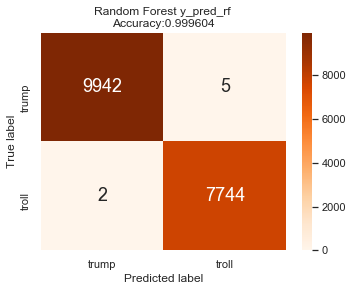

In [94]:
cmx = confusion_matrix(y3_test, y_pred_rf)

# Transform to df for easier plotting
cmx_df = pd.DataFrame(cmx,
                     index = ['trump','troll'], 
                     columns = ['trump','troll'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cmx_df, annot=True, annot_kws={"size": 18},cmap='Oranges',fmt='g')

plt.title('Random Forest y_pred_rf \nAccuracy:{0:2f}'.format(accuracy_score(y3_test, y_pred_rf)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [103]:
from xgboost import XGBClassifier

xg = XGBClassifier(n_estimators = 100, random_state = 21)

xg.fit(X3_train, y3_train)
y_pred_xg = xg.predict(X3_test)

In [104]:
acc = accuracy_score(y3_test, y_pred_xg)
prec = precision_score(y3_test, y_pred_xg)
rec = recall_score(y3_test, y_pred_xg)
f1 = f1_score(y3_test, y_pred_xg)
confusion = confusion_matrix(y3_test, y_pred_xg)
roc_auc = roc_auc_score(y3_test, y_pred_xg)

print(f"Accuracy: {acc}\tPrecision: {prec}\tRecall: {rec}\tF-1: {f1}\tRoc_Auc: {roc_auc}\tConfusion: {confusion}")

Accuracy: 1.0	Precision: 1.0	Recall: 1.0	F-1: 1.0	Roc_Auc: 1.0	Confusion: [[9947    0]
 [   0 7746]]


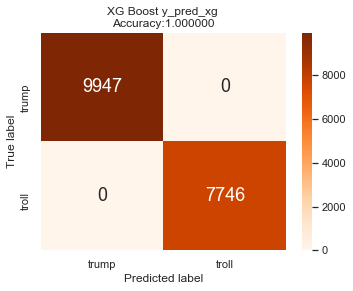

In [107]:
cmxg = confusion_matrix(y3_test, y_pred_xg)

# Transform to df for easier plotting
cmxg_df = pd.DataFrame(cmxg,
                     index = ['trump','troll'], 
                     columns = ['trump','troll'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cmxg_df, annot=True, annot_kws={"size": 18},cmap='Oranges',fmt='g')

plt.title('XG Boost y_pred_xg \nAccuracy:{0:2f}'.format(accuracy_score(y3_test, y_pred_xg)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### 2.8 Document Frequency: What's providing predictive power?

In [61]:
# Document Frequency
vectorizer = TfidfVectorizer(min_df=2, max_features = 5000, ngram_range=(1, 2), stop_words='english')

X_train_idf = vectorizer.fit(df2.lemm) # Use `fit` to learn the vocabulary
X_test_idf = vectorizer.transform(df2.lemm).toarray()

# Rows are documents, columns are terms (aka "tokens" or "features", individual words in this situation).
X_train_idf

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=5000, min_df=2,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [98]:
def get_feature_importances(vocabulary, rf, top_n):
    vocab_features = sorted(vocabulary.items(), key=lambda x: x[1])
    importances = zip(vocab_features, rf)
    
    for z in sorted(importances, key=lambda x: abs(x[1]), reverse=True)[:top_n]:
        print(z)

get_feature_importances(vectorizer.vocabulary_, rf.feature_importances_, 25)

#remember these are words that are just powerful features, not whether they're positive or negative. the number
#next to the word (e.g. horrible,424) is the location on the matrix (aka the column ID)

(('00', 0), 0.4239403114178702)
(('ceo', 887), 0.05852106811502471)
(('hillary https', 2007), 0.05193381953148703)
(('tcot https', 3999), 0.019163589362940093)
(('good idea', 1815), 0.01728160580670582)
(('window', 4500), 0.013683405056586793)
(('8pm', 306), 0.013182723784570612)
(('taylor', 3995), 0.011333712145566744)
(('insane', 2165), 0.010880483925027879)
(('warm', 4413), 0.009067049849340227)
(('taxes', 3993), 0.007951344536382967)
(('apartment', 491), 0.007527330103271201)
(('hillary ha', 2006), 0.007167433987752698)
(('tour', 4148), 0.00593866245699119)
(('deputy', 1271), 0.005135240072174533)
(('thought', 4071), 0.004815817718858765)
(('msm', 2779), 0.004797249823361102)
(('neighborhood', 2843), 0.004777074091273793)
(('news media', 2866), 0.0046658723887274866)
(('pm est', 3134), 0.004652002703593119)
(('fit', 1662), 0.004477491344391687)
(('interested', 2179), 0.004165674511626074)
(('voice', 4360), 0.0039055983300095498)
(('gt https', 1894), 0.0038785657596463272)
(('tcot',